#                                              BDDA - 1 Project
# Submitted To: Prof. Anuj Saini
# Submitted By Group : 8

### 1. Prakriti Nagpal (035002)
### 2. Anjanay (035008)
### 3. Ankita Nagvanshi (035010)
### 4. Riya Girdhar (035044)
### 5. Saanchi Tuteja (035046)
### 6. Sneha Thiyagaran (035054)


## Assignment 4

# Life Expectancy Case Study

## Context 
    
Many studies have been undertaken in the past on factors affecting life expectancy, considering demographic variables, income composition, and mortality rates. It was found that the effect of immunization and human development index was not taken into account in the past studies, and important immunizations like Hepatitis B, Polio, and Diphtheria should also be taken into account. In this case study, we will consider immunization factors, mortality factors, economic factors, social factors, and other health-related factors and use linear regression to see the effect of those factors on Life Expectancy.


## Objective
To analyze the data and build a linear regression model that can predict the life expectancy of the people of a country.


## Key Questions

- Does life expectancy have a positive or negative correlation with the different factors (immunization, mortality, socio-economic, etc.) taken into consideration for the countries?
- Can we build a linear model to predict life expectancy? If yes, how accurate will the model be?


## Data Description

The dataset contains immunization factors, mortality factors, economic factors, social factors, and other health-related factors for different countries across different years.

**Data Dictionary**

- Country: Country
- Year: Year
- Status: Developed or Developing status
- Life expectancy: Life Expectancy in years
- Adult Mortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
- Infant deaths: Number of Infant Deaths per 1000 population
- Alcohol: Alcohol, recorded per capita (15+) consumption (in liters of pure alcohol)
- percentage expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
- Hepatitis B: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
- Measles: number of reported cases of Measles per 1000 population
- BMI: Average Body Mass Index of the entire population
- under-five deaths: Number of under-five deaths per 1000 population
- Polio: Polio (Pol3) immunization coverage among 1-year-olds (%)
- Total expenditure: General government expenditure on health as a percentage of total government expenditure (%)
- Diphtheria: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
- HIV/AIDS: Deaths per 1000 live births due to HIV/AIDS (0-4 years)
- GDP: Gross Domestic Product per capita (in USD)
- Population: Population of the country
- thinness  1-19 years: Prevalence of thinness among children and adolescents for Age 10 to 19 (% )
- thinness 5-9 years: Prevalence of thinness among children for Age 5 to 9(%)
- Income composition of resources: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- Schooling: Number of years of schooling

# Fetching data

In [3]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("LifeExpectancyAnalysis").getOrCreate()

# Load the dataset
df = spark.read.csv("file:////home/ashok/Downloads/datasets/Life Expectancy Data.csv", header=True, inferSchema=True)

# Explore basic statistics
df.describe().show()

# Check for missing values
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


23/09/28 21:52:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
+-------+-----------+------------------+----------+-----------------+------------------+------------------+------------------+----------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+-------------------------------+------------------+
|summary|    Country|              Year|    Status|  Life expectancy|   Adult Mortality|     Infant deaths|           Alcohol|Percentage expenditure|       Hepatitis B|           Measles|               BMI|Under-five deaths|             Polio| Total expenditure|       Diphtheria|          HIV/AIDS|               GDP|          Population|Thinness  1-19 years|Thinness 5-9 years|Income composition of resources|         Schooling|
+-------+---------

In [5]:
# Check the column names in the DataFrame
print(df.columns)


['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'Infant deaths', 'Alcohol', 'Percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness  1-19 years', 'Thinness 5-9 years', 'Income composition of resources', 'Schooling']


# Performing Data Preprocessing

In [6]:
# Handle missing values (e.g., fill with mean or median)
from pyspark.sql.functions import mean

mean_values = df.select([mean(col(c)).alias(c) for c in df.columns if c not in ["Country", "Year", "Status"]])

for col_name in mean_values.columns:
    df = df.na.fill(mean_values.first()[col_name], subset=[col_name])

# Encoding categorical variables (if any)
# Example: Using StringIndexer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Status", outputCol="StatusIndex")
indexed_df = indexer.fit(df).transform(df)

# Assemble features into a vector
feature_cols = [
    "Adult Mortality", "Infant deaths", "Alcohol", "Percentage expenditure", "Hepatitis B",
    "Measles", "BMI", "Under-five deaths", "Polio", "Total expenditure", "Diphtheria", "HIV/AIDS",
    "GDP", "Population", "Thinness  1-19 years", "Thinness 5-9 years",
    "Income composition of resources", "Schooling", "StatusIndex"
]

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(indexed_df)

# Scale features using StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)


23/09/28 21:53:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Performing EDA

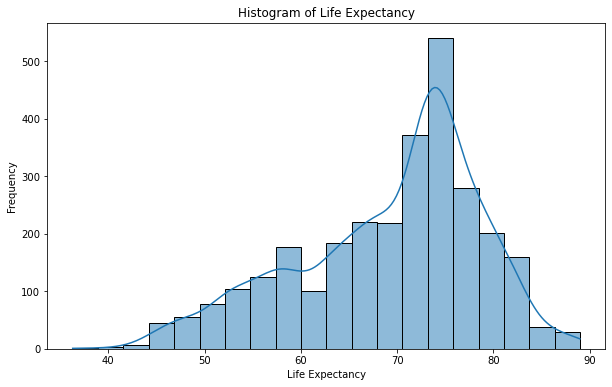

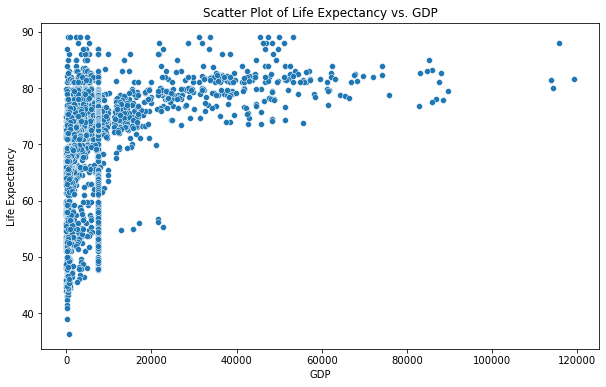

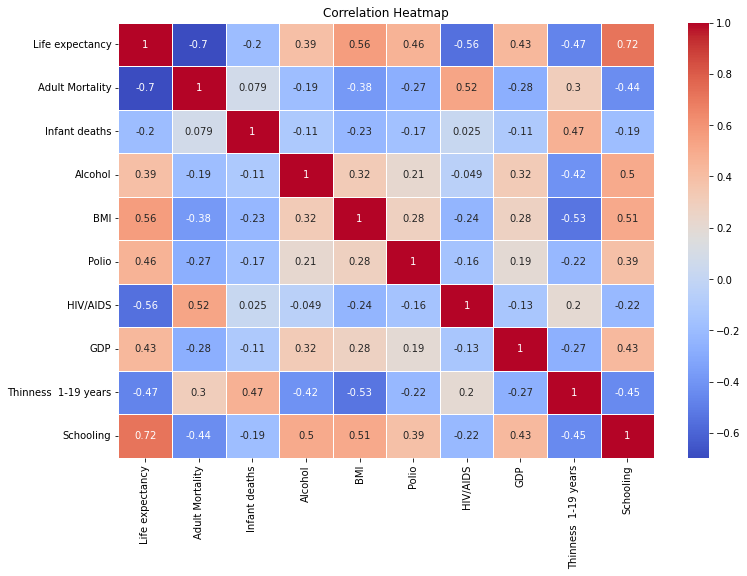

In [7]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns


# Select columns for visualization
selected_columns = [
    "Life expectancy", "Adult Mortality", "Infant deaths", "Alcohol",
    "BMI", "Polio", "HIV/AIDS", "GDP", "Thinness  1-19 years", "Schooling"
]

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.select(selected_columns).toPandas()

# Example 1: Histogram of Life Expectancy
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas["Life expectancy"], bins=20, kde=True)
plt.title("Histogram of Life Expectancy")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.show()

# Example 2: Scatter Plot of Life Expectancy vs. GDP
plt.figure(figsize=(10, 6))
sns.scatterplot(x="GDP", y="Life expectancy", data=df_pandas)
plt.title("Scatter Plot of Life Expectancy vs. GDP")
plt.xlabel("GDP")
plt.ylabel("Life Expectancy")
plt.show()

# Example 3: Correlation Heatmap
correlation_matrix = df_pandas[selected_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


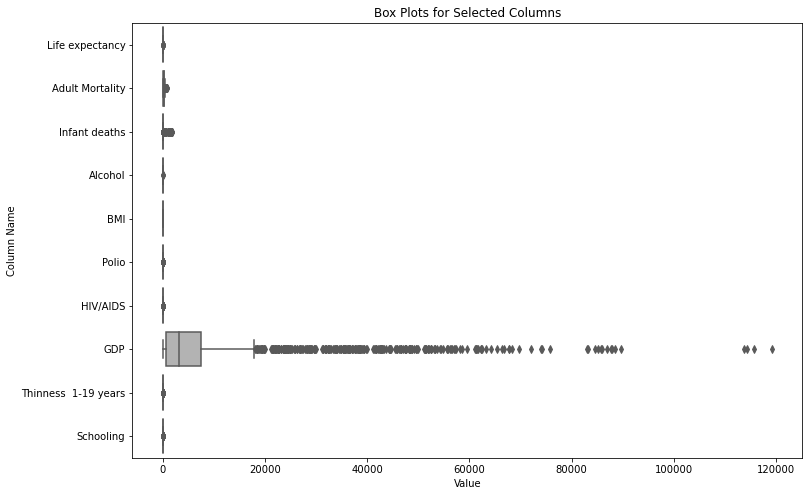

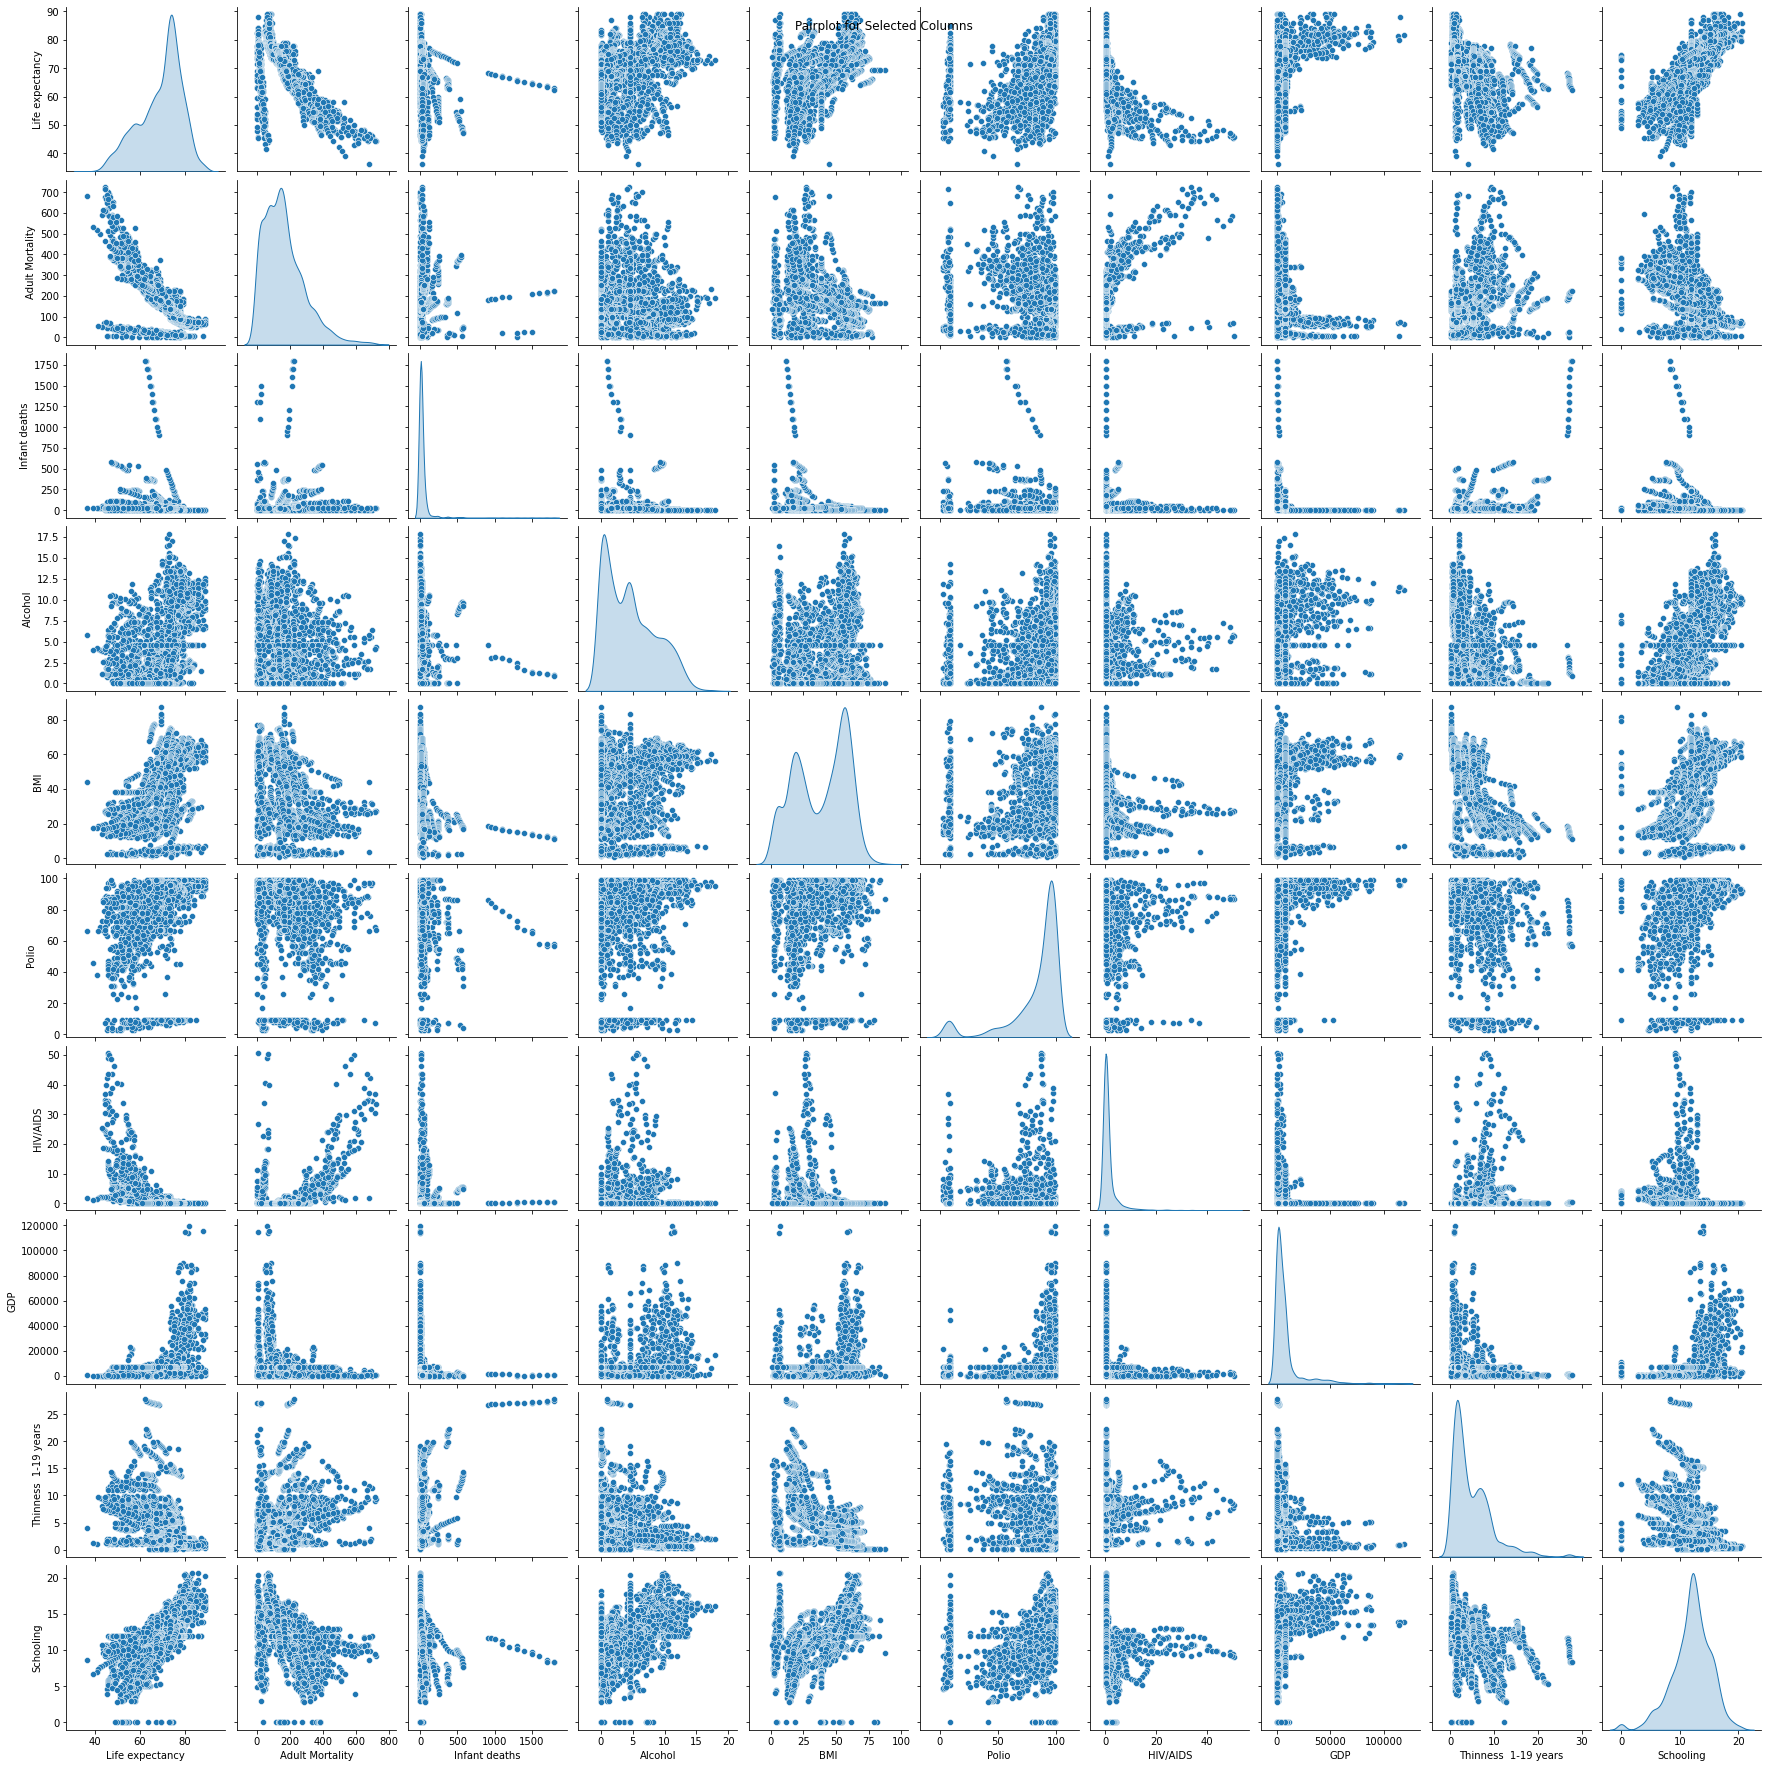

In [8]:
# Example 4: Box Plots for Selected Columns
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_pandas[selected_columns], orient="h", palette="Set2")
plt.title("Box Plots for Selected Columns")
plt.xlabel("Value")
plt.ylabel("Column Name")
plt.show()

# Example 5: Pairplot for Selected Columns
sns.pairplot(df_pandas[selected_columns], diag_kind="kde", markers="o", palette="viridis")
plt.suptitle("Pairplot for Selected Columns")
plt.show()


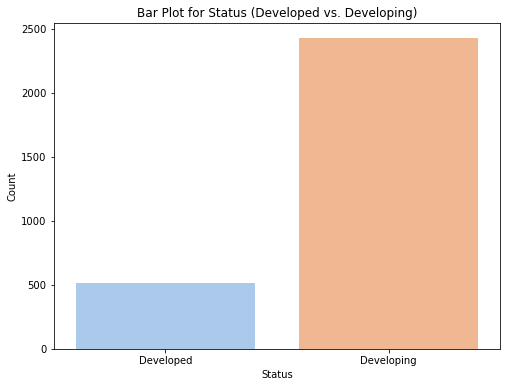

In [9]:
# Example 6: Bar Plot for Status (Developed vs. Developing)
status_counts = df.groupBy("Status").count().toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(x="Status", y="count", data=status_counts, palette="pastel")
plt.title("Bar Plot for Status (Developed vs. Developing)")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

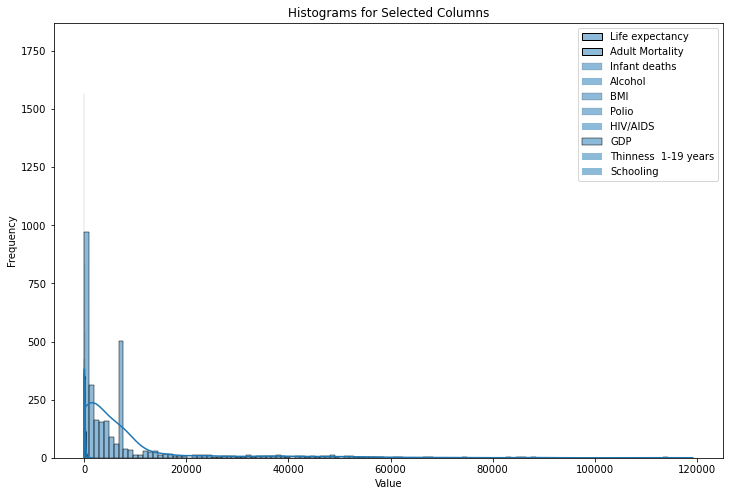

In [10]:
# Example 7: Histograms
plt.figure(figsize=(12, 8))
for column in selected_columns:
    sns.histplot(df_pandas[column], kde=True, label=column)
plt.title("Histograms for Selected Columns")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Top Selected Features:
HIV/AIDS: 0.3418251116005233
Adult Mortality: 0.26313763674280605
Schooling: 0.17073171240275922
BMI: 0.07925923126307086
Infant deaths: 0.044400819661283265


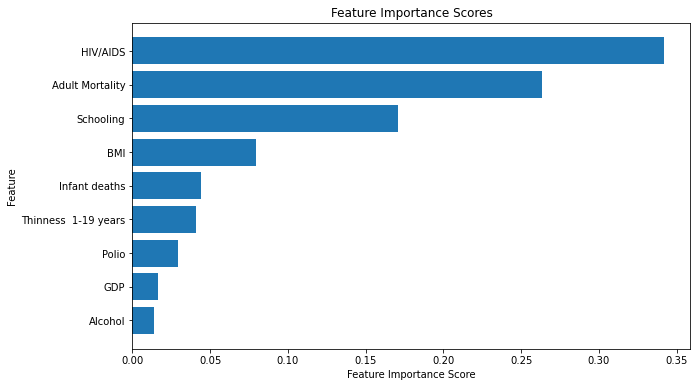

In [11]:
#feature selection
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt


# Select columns for modeling
selected_columns = [
    "Life expectancy", "Adult Mortality", "Infant deaths", "Alcohol",
    "BMI", "Polio", "HIV/AIDS", "GDP", "Thinness  1-19 years", "Schooling"
]

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.select(selected_columns).toPandas()

# Assemble features into a vector
feature_cols = [
    "Adult Mortality", "Infant deaths", "Alcohol",
    "BMI", "Polio", "HIV/AIDS", "GDP", "Thinness  1-19 years", "Schooling"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create a Random Forest Regressor for feature selection
rf = RandomForestRegressor(labelCol="Life expectancy", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_data)

# Get feature importance scores
feature_importance = rf_model.featureImportances

# Create a list of feature names and their importance scores
feature_names = feature_cols
feature_scores = feature_importance.toArray().tolist()

# Combine feature names and scores
feature_rankings = list(zip(feature_names, feature_scores))

# Sort features by importance score in descending order
feature_rankings.sort(key=lambda x: x[1], reverse=True)

# Select the top N features (e.g., top 5)
top_features = [feature for feature, score in feature_rankings[:5]]

# Display the top selected features
print("Top Selected Features:")
for feature, score in feature_rankings[:5]:
    print(f"{feature}: {score}")

# Visualize the feature importance scores
plt.figure(figsize=(10, 6))
plt.barh([feature for feature, _ in feature_rankings], [score for _, score in feature_rankings])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance Scores")
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()


# Building various models for Life Expectancy prediction

In [12]:
#linear regression for prediction

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# Select columns for modeling
selected_columns = [
    "Life expectancy", "HIV/AIDS", "Adult Mortality", "Schooling", "BMI", "Infant deaths"
]

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = scaled_df.select(selected_columns).toPandas()

# Assemble selected features into a vector
feature_cols = ["HIV/AIDS", "Adult Mortality", "Schooling", "BMI", "Infant deaths"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create and train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy")
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Life expectancy", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Display model coefficients
print("Model Coefficients:")
coefficients = lr_model.coefficients
for i in range(len(feature_cols)):
    print(f"{feature_cols[i]}: {coefficients[i]}")

# Display the model summary
print("Model Summary:")
print(f"R-squared: {lr_model.summary.r2}")
print(f"Root Mean Squared Error (RMSE): {lr_model.summary.rootMeanSquaredError}")
print(f"Mean Absolute Error (MAE): {lr_model.summary.meanAbsoluteError}")


23/09/28 21:53:44 WARN Instrumentation: [1b1c7249] regParam is zero, which might cause numerical instability and overfitting.
23/09/28 21:53:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/28 21:53:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/09/28 21:53:44 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
Root Mean Squared Error (RMSE): 4.656021370782156
Model Coefficients:
HIV/AIDS: -0.5141324453027624
Adult Mortality: -0.023264928085301062
Schooling: 1.2890075274054582
BMI: 0.0650338194438095
Infant deaths: -0.0035442126909083715
Model Summary:
R-squared: 0.7608889890257257
Root Mean Squared Error (RMSE): 4.588439202832865
Mean Absolute Error (MAE): 3.3355365490329514


In [13]:
#random forrest regressor
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Select columns for modeling
selected_columns = [
    "Life expectancy", "HIV/AIDS", "Adult Mortality", "Schooling", "BMI", "Infant deaths"
]

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = scaled_df.select(selected_columns).toPandas()

# Assemble selected features into a vector
feature_cols = ["HIV/AIDS", "Adult Mortality", "Schooling", "BMI", "Infant deaths"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Create and train a Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy", numTrees=100)
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Life expectancy", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Display feature importances
print("Feature Importances:")
feature_importance = rf_model.featureImportances
for i in range(len(feature_cols)):
    print(f"{feature_cols[i]}: {feature_importance[i]}")

# Display the model summary
print("Model Summary:")
print(f"Num Trees: {rf_model.getNumTrees}")


Root Mean Squared Error (RMSE): 3.0783179567014374
Feature Importances:
HIV/AIDS: 0.42494999010870294
Adult Mortality: 0.27338286175580195
Schooling: 0.19960531643647603
BMI: 0.04958258653743272
Infant deaths: 0.05247924516158644
Model Summary:
Num Trees: 100


# Performing Hyperparameter Tuning 

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy")

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator for regression (e.g., RMSE)
lr_evaluator = RegressionEvaluator(labelCol="Life expectancy", predictionCol="prediction", metricName="rmse")

# Create a CrossValidator for hyperparameter tuning
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=lr_evaluator,  # Use the defined evaluator
                          numFolds=5)  # Number of cross-validation folds

# Perform hyperparameter tuning
lr_model_tuned = crossval.fit(train_data)

# Get the best model
best_lr_model = lr_model_tuned.bestModel

# Evaluate the best model
best_lr_predictions = best_lr_model.transform(test_data)

# Calculate RMSE for the tuned Linear Regression model
best_lr_rmse = lr_evaluator.evaluate(best_lr_predictions)
print(f"Tuned Linear Regression RMSE: {best_lr_rmse:.2f}")


Tuned Linear Regression RMSE: 4.11


In [17]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Life expectancy")

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define the evaluator for regression (e.g., RMSE)
rf_evaluator = RegressionEvaluator(labelCol="Life expectancy", predictionCol="prediction", metricName="rmse")

# Create a CrossValidator for hyperparameter tuning
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=rf_evaluator,  # Use the defined evaluator
                          numFolds=5)  # Number of cross-validation folds

# Perform hyperparameter tuning
rf_model_tuned = crossval.fit(train_data)

# Get the best Random Forest model
best_rf_model = rf_model_tuned.bestModel

# Evaluate the best model
best_rf_predictions = best_rf_model.transform(test_data)

# Calculate RMSE for the tuned Random Forest Regressor model
best_rf_rmse = rf_evaluator.evaluate(best_rf_predictions)
print(f"Tuned Random Forest Regressor RMSE: {best_rf_rmse:.2f}")


23/09/28 21:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1300.2 KiB
23/09/28 21:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1652.4 KiB
23/09/28 21:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1993.9 KiB
23/09/28 21:56:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/09/28 21:56:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/09/28 21:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1244.8 KiB
23/09/28 21:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1801.4 KiB
23/09/28 21:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1244.8 KiB
23/09/28 21:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1801.4 KiB
23/09/28 21:56:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/09/28 21:56:32 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/09/28 21:56:32 WARN DAGSchedul

23/09/28 21:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1165.0 KiB
23/09/28 21:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1819.8 KiB
23/09/28 21:57:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/09/28 21:57:37 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/09/28 21:57:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/09/28 21:57:38 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/09/28 21:57:39 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/09/28 21:57:40 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
23/09/28 21:57:42 WARN DAGScheduler: Broadcasting large task binary with size 1001.2 KiB
23/09/28 21:57:43 WARN DAGScheduler: Broadcasting large task binary with size 1001.2 KiB
23/09/28 21:57:43 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
23/09/28 21:57:43 WARN DAGScheduler: Br

In [20]:
#this is the end